In [56]:
import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput)

import ProcessGenMetrics
import pandas as pd

from typing import Dict, Optional
def get_gen_summary(path) -> GenerationSummary:
    def json_to_instance_generation(instance_dict:dict) -> InstanceGenerations:
        instance_generation = InstanceGenerations(**instance_dict)
        examples = [ GeneratedOutput(**generated_output_dict) for generated_output_dict in instance_generation.examples]
        instance_generation.examples=examples
        return instance_generation
    with open(path,'r') as json_file:
        generation_summary_dict=json.load(json_file)
    generation_summary=GenerationSummary(**generation_summary_dict)
    instance_generations = [json_to_instance_generation(instance_dict)  for instance_dict in generation_summary.instance_generations ]
    generation_summary.instance_generations=instance_generations
    return generation_summary

def truncate_sequence(text:str, all_stops=["<|end_of_text|>"]) -> str:
    for stop in all_stops:
        try:
            text = text[: text.index(stop)]
        except ValueError:
            pass
    return text.strip()

class ProcessGens:
    base_folder:str
    beam_num_to_summary:Dict[int, GenerationSummary]
    metrics_dict:List[Dict[str,any]]

    def __init__(self,base_folder:str, num_beams_list:List[int], models:List[float], custom_metrics:List[ProcessGenMetrics.PostMetric],eval_instances:str=None):
        

        self.base_folder=base_folder

        # #these are by themselves
        print("get_metrics_df")
        metrics_df=self.get_metrics_df(base_folder)
        print("get_instance_info")
        instance_info=self.get_instance_info(base_folder, num_beams_list, models)
        self.metrics_df=metrics_df
        self.instance_info=instance_info

        
       
        #these go together
        print("calculate_beam_num_to_summary")
        beam_num_to_summary=self.calculate_beam_num_to_summary(base_folder, num_beams_list, models,eval_instances)
        print("get_metrics_dict")
        metrics_dicts=self.get_metrics_dict(beam_num_to_summary, custom_metrics)

        
        


        self.beam_num_to_summary=beam_num_to_summary
        self.metrics_dicts=metrics_dicts

    def clean_generation_summary(generationSummary:GenerationSummary, eval_instances:int=None)->GenerationSummary:
        def clean_instance_generation(instanceGenerations:InstanceGenerations)->InstanceGenerations:
            def clean_generated_output(generatedOutput:GeneratedOutput)-> GeneratedOutput:
                generatedOutput.text=truncate_sequence(generatedOutput.text)
                return generatedOutput
            instanceGenerations.examples=[clean_generated_output(example) for example in instanceGenerations.examples]
            instanceGenerations.completion=truncate_sequence(instanceGenerations.completion)
            return instanceGenerations
        generationSummary.instance_generations=[clean_instance_generation(instance_generation) for instance_generation in generationSummary.instance_generations]
        if(eval_instances):
            generationSummary.instance_generations=generationSummary.instance_generations[:eval_instances]
        return generationSummary



    @classmethod  
    def get_instance_info(self, base_folder, num_beams_list:List[int], models:List[float])->Dict[int, GenerationSummary]:
        num_beams=num_beams_list[0]
        model=models[0]
        instance_infos= {}
        instance_metrics=[ProcessGenMetrics.ReferenceMetric()]
        path=f"{base_folder}/wmt/{model}/{num_beams}_beams/runs/eval_600/generation_summary.json"
        generation_summary=get_gen_summary(path)
        for instance_generation in generation_summary.instance_generations:
            instance_id=instance_generation.instance_id
            if instance_id not in instance_infos.keys():
                instance_dict={}
                for metric in instance_metrics:
                    ProcessGenMetrics.calculate_post_metric(instance_dict,metric,instance_generation,None)
                instance_infos[instance_id]=instance_dict
        return instance_infos

    @classmethod  
    def calculate_beam_num_to_summary(self, base_folder, num_beams_list:List[int], models:List[float], eval_instances:int=None)->Dict[int, GenerationSummary]:
        beam_num_to_summary= {}
        for num_beams in num_beams_list:
            for model in models:
                path=f"{base_folder}/wmt/{model}/{num_beams}_beams/runs/eval_600/generation_summary.json"
                print(f"Analyzing path: {path}")
                raw_generation_summary=get_gen_summary(path)
                
                generation_summary:GenerationSummary=self.clean_generation_summary(raw_generation_summary, eval_instances)
                if(eval_instances):
                    assert len(generation_summary.instance_generations)==eval_instances
                beam_num_to_summary[num_beams]=generation_summary
        return beam_num_to_summary

    @classmethod  
    def get_metrics_dict(self, beam_num_to_summary:Dict[int, GenerationSummary], custom_metrics:List[ProcessGenMetrics.PostMetric]):
        base_metrics=[ProcessGenMetrics.TextMetric,ProcessGenMetrics.SentenceLenMetric(),ProcessGenMetrics.OutputProbMetric(),
                       ProcessGenMetrics.InstanceIdMetric(), ProcessGenMetrics.IsCompletionMetric()]
        metrics=base_metrics+custom_metrics
        metrics_dicts=[]
        for beam_num, generation_summary in beam_num_to_summary.items():
            print(beam_num)
            for instance_generation in generation_summary.instance_generations:
                for idx,generated_output in enumerate(instance_generation.examples):
                    pd_metrics_dict={}
                    for metric in metrics:
                        ProcessGenMetrics.calculate_post_metric(pd_metrics_dict,metric,instance_generation,generated_output)
                    pd_metrics_dict["beam_num"]=beam_num
                    pd_metrics_dict["isCompletion"]=(idx==0)
                    
                    metrics_dicts.append(pd_metrics_dict)
        return metrics_dicts

    @classmethod  
    def get_metrics_df(self, base_folder):
        metrics_file=f"{base_folder}/metrics_csv.txt"
        raw_metric_df = pd.read_csv(metrics_file, header=None)
        raw_metric_df.columns=[ "model", "task", "beam_num", "metric", "value"]
        raw_metric_df.drop(["task"],axis=1)
        metric_df = raw_metric_df.pivot(
            index=["model", "beam_num"],
            columns="metric",
            values="value"
        ).reset_index()
        metric_df.sort_values("beam_num")
        return metric_df
    




In [57]:
num_beams_list=[2,4,8,64]
models=["meta_llama_Llama_3.1_8B_Instruct"]
eval_instances=600
custom_metrics=[ ProcessGenMetrics.BLEU1_METRIC(),ProcessGenMetrics.BLEU4_METRIC()]
base_folder="snellius_copies/wmt_full/eval_600"
processGens= ProcessGens(base_folder=base_folder,num_beams_list=num_beams_list,models=models,custom_metrics=custom_metrics, eval_instances=eval_instances)







get_metrics_df
get_instance_info
calculate_beam_num_to_summary
Analyzing path: snellius_copies/wmt_full/eval_600/wmt/meta_llama_Llama_3.1_8B_Instruct/2_beams/runs/eval_600/generation_summary.json
Analyzing path: snellius_copies/wmt_full/eval_600/wmt/meta_llama_Llama_3.1_8B_Instruct/4_beams/runs/eval_600/generation_summary.json
Analyzing path: snellius_copies/wmt_full/eval_600/wmt/meta_llama_Llama_3.1_8B_Instruct/8_beams/runs/eval_600/generation_summary.json
Analyzing path: snellius_copies/wmt_full/eval_600/wmt/meta_llama_Llama_3.1_8B_Instruct/64_beams/runs/eval_600/generation_summary.json
get_metrics_dict
2


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

4
8
64


In [67]:

# ids=[instance_generations.instance_id for instance_generations in processGens.beam_num_to_summary[2].instance_generations]
# for id in ids[:10]:
#     print("\n")
#     for beam_num in num_beams_list:
#         for instance_generation in processGens.beam_num_to_summary[beam_num].instance_generations:
#             if(instance_generation.instance_id==id):
#                 example_logprobs=[example.logprob for example in instance_generation.examples]
#                 # print(f"beam_num:{beam_num}\t log_prob:{instance_generation.completion_logprob}")
#                 print(f"beam_num:{beam_num}\t max_p:{max(example_logprobs)}")

import statistics


for beam_num in num_beams_list:
    max_log_probs=[]
    for instance_generation in processGens.beam_num_to_summary[beam_num].instance_generations:
        example_logprobs=[example.logprob for example in instance_generation.examples]
        max_log_probs.append(max(example_logprobs))
    print(f"beam num: {beam_num}. \tAve:{statistics.mean(max_log_probs)}")
    

        

beam num: 2. 	Ave:-45.91055334388232
beam num: 4. 	Ave:-58.95381327950606
beam num: 8. 	Ave:-63.12108083788269
beam num: 64. 	Ave:-49.452238867100654


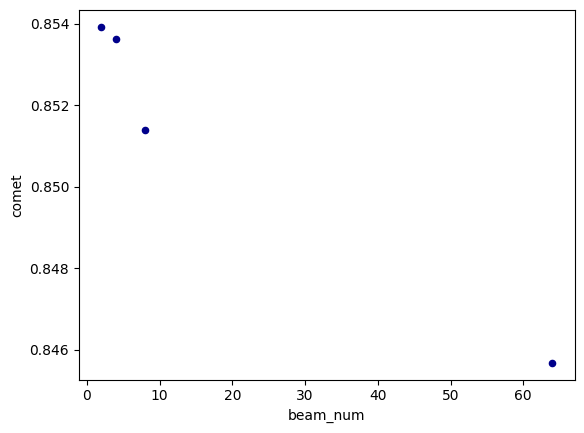

In [59]:
ax1 = processGens.metrics_df.plot.scatter(x='beam_num',y='comet',c='DarkBlue')


In [60]:
import pandas as pd
examples_df = pd.DataFrame(processGens.metrics_dicts)
completions_df=examples_df.loc[examples_df['isCompletion'] == True]

print(completions_df.columns)
print(f"Num examples: {examples_df.shape[0]}")
print(f"Num completions: {completions_df.shape[0]}")

if(eval_instances):
    assert sum(num_beams_list)*eval_instances==examples_df.shape[0]
    assert len(num_beams_list)*eval_instances==completions_df.shape[0]


Index(['text', 'completion_length', 'output_logprob', 'instanceID',
       'isCompletion', 'BLEU_1', 'BLEU_4', 'beam_num'],
      dtype='object')
Num examples: 46800
Num completions: 2400


Mean output_logprob for 2:	 -53.62950928303959
Mean output_logprob for 64:	 -159.26065117987065
Mean Change:-105.63114189683105
Median Change:-59.8204564449843


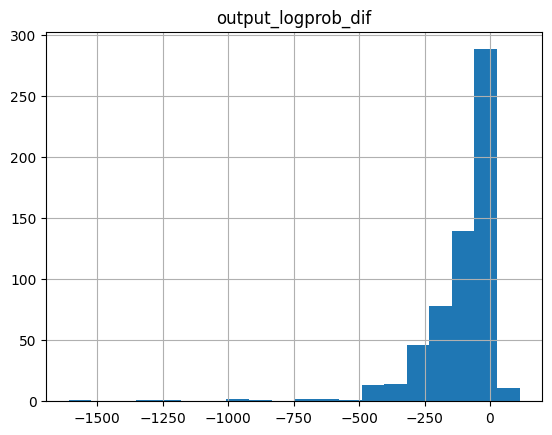

In [61]:
def compare_beams_by_metric(analysis_df,compare_metric,compare_beams, compare_func= lambda a,b: b-a,plot_histogram=True):

    for beam_num in compare_beams:
        filtered_df=analysis_df.loc[analysis_df['beam_num']==beam_num]
        print(f"Mean {compare_metric} for {beam_num}:\t {filtered_df[compare_metric].mean()}")
    col_names=[f"{compare_metric}_{beam_num}" for beam_num in compare_beams]
    dif_col=f'{compare_metric}_dif'

    result = analysis_df[analysis_df['beam_num'].isin(compare_beams)][['instanceID', 'beam_num', compare_metric]]
    pivoted = result.pivot(index='instanceID', columns='beam_num', values=compare_metric)
    pivoted.columns = col_names
    pivoted = pivoted.reset_index()
    pivoted[dif_col] = pivoted.apply(lambda row: compare_func(row[col_names[0]],row[col_names[1]]), axis=1)
    print(f"Mean Change:{pivoted[dif_col].mean()}")
    print(f"Median Change:{pivoted[dif_col].median()}")
    if(plot_histogram):
        pivoted.hist(column=dif_col,bins=20)

# #Extremely slight positive change for BLEU_1 from 2--)4:
# compare_beams_by_metric(analysis_df=completions_df,compare_metric='BLEU_1', compare_beams=[2, 4])

# #25.1% of samples are different between 2 and 64
# compare_beams_by_metric(analysis_df=completions_df,compare_metric='BLEU_1', compare_beams=[2, 4], compare_func=lambda a,b: a!=b, plot_histogram=False)


#expectation: we will see an increase in logprob from 2--)4, so diff will be positive
# compare_beams_by_metric(analysis_df=completions_df,compare_metric='output_logprob', compare_beams=[2, 64])
compare_beams_by_metric(analysis_df=completions_df,compare_metric='output_logprob', compare_beams=[2, 64])

# completion_length








In [62]:

# processGens.id_to_example_metrics=processGens.get_id_to_example_metrics( processGens.metrics_dicts)

# # def get_completion_metrics(example_metrics_dicts):
# #     completion_metrics=[example_metrics for example_metrics_dicts]


# def filter_by_metric(metrics_dict, ):


# import os

# metrics_instance_examples=processGens.id_to_example_metrics["id24769"]

# metrics_instance_completions=[metrics_instance_example for metrics_instance_example in  metrics_instance_examples if ]




# counter=0
# filename="b.txt"
# os.remove(filename)

# for instanceID, metrics_dicts_all_beams  in processGens.id_to_example_metrics.items():
#     for 

#     bleu_2=metrics_dicts_all_beams[2][ProcessGens.BLEU1_METRIC().name()]
#     bleu_64=metrics_dicts_all_beams[64][ProcessGens.BLEU1_METRIC().name()]
#     if bleu_2 != bleu_64:

#         refererence=processGens.instance_info[instanceID]

#         with open(filename,"a") as file:    
#             file.write(f"reference: \t\t{refererence} \n")
            
#             for beam_num in [2,64]
#             for metrics_dict in metrics_dicts:
#                 beam_num=metrics_dict[ProcessGens.BeamNumMetric().name()]
#                 bleu=metrics_dict[ProcessGens.BLEU1_METRIC().name()]
#                 completion=metrics_dict[ProcessGens.BLEU1_METRIC().name()]
#                 if(beam_num in [2,64]):
                    
#                         firstOne=False
#                     file.write(f"beam_num: {beam_num} \tbleu: {bleu}, \t text: {completionSummary.completion} \n")


# for instanceID, completionSummaryDict in instanceIdToMetrics.items():
#     firstOne=True

In [63]:
for num_beams in num_beams_list:
    bleu=df.loc[(df['beam_num']==num_beams) & (df['isCompletion'] == True)]["BLEU"].mean()
    print(f"beam_num: {num_beams}, bleu: {bleu}")


NameError: name 'df' is not defined

In [8]:
print()

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_keys(xlabel, ylabel):
    x=df[xlabel]
    y=df[ylabel]
    plt.scatter(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.show()

plot_keys("completion_logprob","BLEU")


KeyError: 'completion_logprob'

In [35]:


# for instance_generation in instance_generations:
#     for generated_output in instance_generation.examples:
#         if(generated_output.logprob>-50):
#             instance_generation.reference
#             print(generated_output.text)
#             print(" ".join([token["text"] for token in generated_output.tokens]))

 Airbus states that the competing version of the A350 carries 350 people in 18-inch seats in economy class, with nine per row.
 Airbus  states  that  the  competing  version  of  the  A 350  carries   350  people  in   18 -inch  seats  in  economy  class ,  with  nine  per  row . <|end_of_text|>
 According to the Associated Press, the target was Russian SA-125 missiles.
 According  to  the  Associated  Press ,  the  target  was  Russian  SA - 125  missiles . <|end_of_text|>
 The text, which was adopted last night, consists of 234 articles.
 The  text ,  which  was  adopted  last  night ,  consists  of   234  articles . <|end_of_text|>
 The text that was adopted last night consists of 234 articles.
 The  text  that  was  adopted  last  night  consists  of   234  articles . <|end_of_text|>
 He only stirs up enthusiasm with difficulty.
 He  only  st irs  up  enthusiasm  with  difficulty . <|end_of_text|>
 He only rarely inspires enthusiasm.
 He  only  rarely  inspires  enthusiasm . <|end_